In [ ]:
!nvidia-smi

Sun Mar 28 08:05:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!unzip /content/jigsaw-toxic-comment-classification-challenge.zip

Archive:  /content/jigsaw-toxic-comment-classification-challenge.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv.zip            
  inflating: test_labels.csv.zip     
  inflating: train.csv.zip           


In [ ]:
!unzip /content/train.csv.zip
!unzip /content/test.csv.zip

Archive:  /content/train.csv.zip
  inflating: train.csv               
Archive:  /content/test.csv.zip
  inflating: test.csv                


In [ ]:
!pip3 install bert-for-tf2
!pip3 install sentencepiece

     |████████████████████████████████| 51kB 6.1MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-cp37-none-any.whl size=30535 sha256=89246a2ff281a2f83a2aa47298208f6242890ce8862cf77596c11c859095cd70
  Stored in directory: /root/.cache/pip/wheels/a1/04/ee/347bd9f5b821b637c76411d280271a857aece00358896a230f
  Created wheel for py-params: filename=py_params-0.10.2-cp37-none-any.whl size=7912 sha256=1d55a136b6a11806125dc827abcf25e6b41e6d0d98cf14cfcc5ded7d3e6a7e6d
  Stored in directory: /root/.cache/pip/wheels/d0/4a/70/ff12450229ff1955abf01f365051d4faae1c20aef53ab4cf09
  Created wheel for params-flow: filename=params_flow-0.8.2-cp37-none-any.whl size=19472 sha256=5c5eef46739e43b0c0c76a66edf6f473a2e951d255f619633a72af5e26f2dcd4
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow
     |████████████████████████████████| 1.2MB 16.8MB/s 


In [ ]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!unzip uncased_L-12_H-768_A-12.zip

--2021-03-28 08:05:40--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.122.128, 172.217.2.112, 172.253.63.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.122.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   237MB/s    in 1.6s    

2021-03-28 08:05:42 (237 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [ ]:
import os
import re
import bert
import nltk
import tqdm
import argparse
import numpy as np
import pandas as pd
import tensorflow as tf
from bert import BertModelLayer
import matplotlib.pyplot as plt
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
class InputPipeline:
  def __init__(self, train_data,test_data,tokenizer,max_length):
    self.train_data = train_data
    self.test_data = test_data
    self.tokenizer = tokenizer
    self.stopwords = nltk.corpus.stopwords.words('english')
    self.max_len = max_length
    self.train_data['comment_text'] = self.train_data['comment_text'].astype(str)
    self.test_data['comment_text'] = self.test_data['comment_text'].astype(str)
    
    self.train_data['cleaned_comment'] = [self.clean_comment(comment) for comment in self.train_data["comment_text"]]
    self.test_data['cleaned_comment'] = [self.clean_comment(comment) for comment in self.test_data["comment_text"]]  

    self.train_data_tokenized_comments = [self.tokenize_comment(comment) for comment in self.train_data['cleaned_comment']]
    self.train_labels = self.train_data.drop(columns=['comment_text','cleaned_comment','id'],axis=1).values
    self.test_data_tokenized_comments = [self.tokenize_comment(comment) for comment in self.test_data['cleaned_comment']]
    self.test_labels = self.test_data.drop(columns=['comment_text','cleaned_comment','id'],axis=1).values

    self.train_input = tf.keras.preprocessing.sequence.pad_sequences(self.train_data_tokenized_comments, padding='post', maxlen=self.max_len)
    self.test_input = tf.keras.preprocessing.sequence.pad_sequences(self.test_data_tokenized_comments, padding='post', maxlen=self.max_len)

  def clean_comment(self,comment):
    comment = nltk.word_tokenize(comment.lower())
    comment = [i for i in comment if i not in self.stopwords]
    comment = " ".join(comment)
    comment = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"\
                              , " ", comment).split())
    return comment     
  
  def tokenize_comment(self,comment):
    return self.tokenizer.convert_tokens_to_ids(["[CLS]"] + self.tokenizer.tokenize(comment)[:self.max_len] + ["[SEP]"])

In [ ]:
class BERT(tf.keras.models.Model):
  def __init__(self,max_len, bert_checkpoint,bert_config):
    super(BERT, self).__init__()
    self.max_len = max_len
    self.bert_checkpoint = bert_checkpoint
    self.bert_config = bert_config
    self.labels = 6
    self.bert = self.call_model()
    self.lambda_layer = tf.keras.layers.Lambda(lambda seq: seq[:, 0, :])
    self.dropout_layer_1 = tf.keras.layers.Dropout(0.5)
    self.dense_layer_1 = tf.keras.layers.Dense(units=768, activation="tanh")
    self.dropout_layer_2 = tf.keras.layers.Dropout(0.5)
    self.dense_layer_2 = tf.keras.layers.Dense(units=self.labels, activation="sigmoid")

  def call_model(self):
    with tf.io.gfile.GFile(self.bert_config, "r") as reader:
      cfg = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(cfg)
      bert_params.adapter_size = None
      bert_model = BertModelLayer.from_params(bert_params)  
      return bert_model

  def call(self,input_tensor):
    x = self.bert(input_tensor)
    x = self.lambda_layer(x)
    x = self.dropout_layer_1(x)
    x = self.dense_layer_1(x)
    x = self.dropout_layer_2(x)
    x = self.dense_layer_2(x)
    return x


                 id  ... identity_hate
0  0000997932d777bf  ...             0
1  000103f0d9cfb60f  ...             0
2  000113f07ec002fd  ...             0
3  0001b41b1c6bb37e  ...             0
4  0001d958c54c6e35  ...             0

[5 rows x 8 columns]
Missing Values id               0.0
comment_text     0.0
toxic            0.0
severe_toxic     0.0
obscene          0.0
threat           0.0
insult           0.0
identity_hate    0.0
dtype: float64


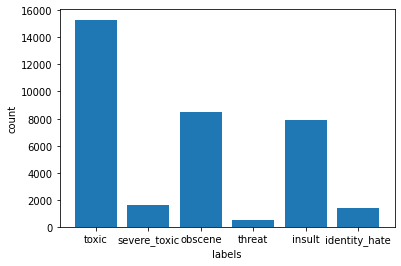

Epoch 1/2
12821/18949 [===================>..........] - ETA: 1:08:03 - loss: 0.1639 - accuracy: 0.6239

In [ ]:
def train_bert():
  train_path = "train.csv"
  test_path = "test.csv"
  bert_main_checkpoint = "uncased_L-12_H-768_A-12/bert_model.ckpt"
  bert_vocab = "uncased_L-12_H-768_A-12/vocab.txt"
  bert_config =  "uncased_L-12_H-768_A-12/bert_config.json"
  max_length = 300
  classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

  train_data = pd.read_csv(train_path)
  test_data = pd.read_csv(test_path)

  print(train_data.head())
  print("Missing Values",((train_data.isnull() | train_data.isna())\
                          .sum() * 100 / train_data.index.size).round(2))
  #EDA
  count_labels = pd.DataFrame(train_data[classes].sum()).reset_index()
  count_labels.columns = ['labels','count']
  bar_graph = plt.bar(count_labels['labels'],count_labels['count'])
  plt.xlabel('labels')
  plt.ylabel('count')
  plt.show()
    
  tokenizer = bert.tokenization.bert_tokenization.FullTokenizer(vocab_file=os.path.join(bert_vocab))
  pipeline = InputPipeline(train_data = train_data,
                         test_data = test_data,
                         tokenizer = tokenizer,
                         max_length = max_length)
  
  bert_model = BERT(max_len=max_length, bert_checkpoint=bert_main_checkpoint,bert_config=bert_config)
  bert_model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss="binary_crossentropy",
  metrics=["accuracy"])

  callback=tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/drive/MyDrive/bert_model_{epoch:02d}.h5',
        monitor='loss',
        save_best_only=False,
        save_weights_only=True,
        mode='min',
        verbose=1)
  history = bert_model.fit(
  x=pipeline.train_input, 
  y=pipeline.train_labels,
  validation_split=0.05,
  batch_size=8,
  shuffle=True,
  epochs=2,
  callbacks=[callback])

  results = bert_model.evaluate(pipeline.test_input,pipeline.test_labels)

if __name__ == "__main__":
  train_bert()